## (2) Picking 10 Bonds

In [76]:
import pandas as pd
import numpy as np

# Load the CSV
df = pd.read_csv('bonds_master_all.csv')

# Convert date columns to datetime
df['date'] = pd.to_datetime(df['date'])
df['Maturity Date'] = pd.to_datetime(df['Maturity Date'])
df['Issue Date'] = pd.to_datetime(df['Issue Date'])

# Remove '%' sign from Coupon and convert to float
df['Coupon'] = df['Coupon'].str.rstrip('%').astype(float)

# Keep one row per ISIN by selecting the earliest date
df_earliest = df.sort_values('date').groupby('ISIN').first().reset_index()

# Retain only the required columns
df_clean = df_earliest[['ISIN', 'Coupon', 'Issue Date', 'Maturity Date']].copy()

# Define anchor date as the earliest date in the dataset
anchor_date = df['date'].min()
print(f"Anchor Date: {anchor_date}")

# Compute time-to-maturity T
df_clean['T'] = (df_clean['Maturity Date'] - anchor_date).dt.days / 365.25

# Sort by T in ascending order
df_clean = df_clean.sort_values('T').reset_index(drop=True)

# Print the sorted table
# print("\nBond Data - Sorted by Time-to-Maturity:")
# print(df_clean[['ISIN', 'Coupon', 'Maturity Date', 'T']].to_string())


Anchor Date: 2026-01-05 00:00:00


In [77]:
selected_isins = [
    "CA135087R978",
    "CA135087L930",
    "CA135087S547",
    "CA135087S885",
    "CA135087T461",
    "CA135087T610",
    "CA135087H235",
    "CA135087Q988",
    "CA135087S471",
    "CA135087L443"
]

df_selected = df[df["ISIN"].isin(selected_isins)].copy()

df_selected = df_selected.sort_values(["Maturity Date", "ISIN"]).reset_index(drop=True)

print(df_selected[["ISIN", "Coupon", "Maturity Date"]].drop_duplicates())


            ISIN  Coupon Maturity Date
0   CA135087R978    4.00    2026-08-03
10  CA135087L930    1.00    2026-09-01
20  CA135087S547    3.00    2027-02-01
30  CA135087S885    2.75    2027-05-01
40  CA135087T461    2.50    2027-08-01
50  CA135087T610    2.50    2027-11-01
60  CA135087H235    2.00    2028-06-01
70  CA135087Q988    4.00    2029-03-01
80  CA135087S471    2.75    2030-03-01
90  CA135087L443    0.50    2030-12-01


## 4(a) YTM & yield curve

In [78]:
from scipy.optimize import brentq

# Prepare the data with time-to-maturity for all selected bonds on all dates
df_ytm = df_selected.copy()
df_ytm['Maturity Date'] = pd.to_datetime(df_ytm['Maturity Date'])
df_ytm['date'] = pd.to_datetime(df_ytm['date'])

# Compute T for each row (time-to-maturity from the observation date)
df_ytm['T'] = (df_ytm['Maturity Date'] - df_ytm['date']).dt.days / 365.25

# Convert Coupon to float if needed
if df_ytm['Coupon'].dtype == 'object':
    df_ytm['Coupon'] = df_ytm['Coupon'].str.rstrip('%').astype(float)
else:
    df_ytm['Coupon'] = df_ytm['Coupon'].astype(float)

# Clean price - convert to float
df_ytm['Clean Price'] = pd.to_numeric(df_ytm['Close Price (% of par)'], errors='coerce')

def compute_dirty_price(coupon_rate, settle_date, maturity_date, clean_price):
    par = 100.0
    freq = 2
    C = coupon_rate / 100 * par / freq

    # step back from maturity to find coupon dates
    coupon_dates = []
    d = maturity_date
    while d > settle_date:
        coupon_dates.append(d)
        d -= pd.DateOffset(months=6)
    next_coupon = coupon_dates[-1]
    last_coupon = d

    days_since = (settle_date - last_coupon).days
    days_period = (next_coupon - last_coupon).days

    accrued_interest = C * days_since / days_period
    return clean_price + accrued_interest

df_ytm['Dirty Price'] = df_ytm.apply(
    lambda row: compute_dirty_price(row['Coupon'], row['date'], row['Maturity Date'], row['Clean Price']),
    axis=1
)
# Print the clean and dirty prices for comparison
print("Clean and Dirty Price Comparison:")
# Display a sample of clean and dirty prices for inspection
print(df_ytm[["ISIN", "date", "Clean Price", "Dirty Price"]].head(10))


Clean and Dirty Price Comparison:
           ISIN       date  Clean Price  Dirty Price
0  CA135087R978 2026-01-05       100.88   102.564783
1  CA135087R978 2026-01-06       100.88   102.575652
2  CA135087R978 2026-01-07       100.88   102.586522
3  CA135087R978 2026-01-08       100.88   102.597391
4  CA135087R978 2026-01-09       100.87   102.598261
5  CA135087R978 2026-01-12       100.86   102.620870
6  CA135087R978 2026-01-13       100.86   102.631739
7  CA135087R978 2026-01-14       100.86   102.642609
8  CA135087R978 2026-01-15       100.86   102.653478
9  CA135087R978 2026-01-16       100.85   102.654348


In [79]:
import numpy as np
from scipy.optimize import brentq
from datetime import timedelta
from dateutil.relativedelta import relativedelta

def compute_ytm(coupon_rate, dirty_price, settle_date, maturity_date):
    freq = 2
    par = 100.0
    c = coupon_rate / 100 * par / freq

    # generate coupon dates backwards from maturity
    coupon_dates = []
    d = maturity_date
    while d > settle_date:
        coupon_dates.append(d)
        d = d - relativedelta(months=6)
    coupon_dates = coupon_dates[::-1]

    # year fractions from settlement to each cash flow
    times = np.array([(d - settle_date).days / 365.25 for d in coupon_dates])

    cash_flows = np.full(len(times), c)
    cash_flows[-1] += par

    def price_diff(y):
        y_semi = y / freq
        dfs = (1 + y_semi) ** (-freq * times)
        return np.sum(cash_flows * dfs) - dirty_price

    try:
        return brentq(price_diff, -0.05, 0.5)
    except ValueError:
        return np.nan

df_ytm['YTM'] = df_ytm.apply(
    lambda row: compute_ytm(row['Coupon'], row['Dirty Price'], row['date'], row['Maturity Date']),
    axis=1
)
result_df = df_ytm[['date', 'ISIN','Dirty Price', 'YTM', 'Coupon', 'Maturity Date']].copy()
print("Daily YTM for Selected Government of Canada Bonds:")

print(result_df.head(20))

Daily YTM for Selected Government of Canada Bonds:
         date          ISIN  Dirty Price       YTM  Coupon Maturity Date
0  2026-01-05  CA135087R978   102.564783  0.024731     4.0    2026-08-03
1  2026-01-06  CA135087R978   102.575652  0.024661     4.0    2026-08-03
2  2026-01-07  CA135087R978   102.586522  0.024591     4.0    2026-08-03
3  2026-01-08  CA135087R978   102.597391  0.024520     4.0    2026-08-03
4  2026-01-09  CA135087R978   102.598261  0.024627     4.0    2026-08-03
5  2026-01-12  CA135087R978   102.620870  0.024591     4.0    2026-08-03
6  2026-01-13  CA135087R978   102.631739  0.024518     4.0    2026-08-03
7  2026-01-14  CA135087R978   102.642609  0.024445     4.0    2026-08-03
8  2026-01-15  CA135087R978   102.653478  0.024371     4.0    2026-08-03
9  2026-01-16  CA135087R978   102.654348  0.024480     4.0    2026-08-03
10 2026-01-05  CA135087L930    99.493066  0.023195     1.0    2026-09-01
11 2026-01-06  CA135087L930    99.495829  0.023250     1.0    2026-09-01


In [80]:
result_df["T"] = (
    (result_df["Maturity Date"] - result_df["date"]).dt.days / 365.25
)
print(result_df[["T", "YTM"]].head(20))

           T       YTM
0   0.574949  0.024731
1   0.572211  0.024661
2   0.569473  0.024591
3   0.566735  0.024520
4   0.563997  0.024627
5   0.555784  0.024591
6   0.553046  0.024518
7   0.550308  0.024445
8   0.547570  0.024371
9   0.544832  0.024480
10  0.654346  0.023195
11  0.651608  0.023250
12  0.648871  0.022991
13  0.646133  0.023125
14  0.643395  0.022705
15  0.635181  0.023029
16  0.632444  0.022924
17  0.629706  0.022818
18  0.626968  0.022711
19  0.624230  0.022603


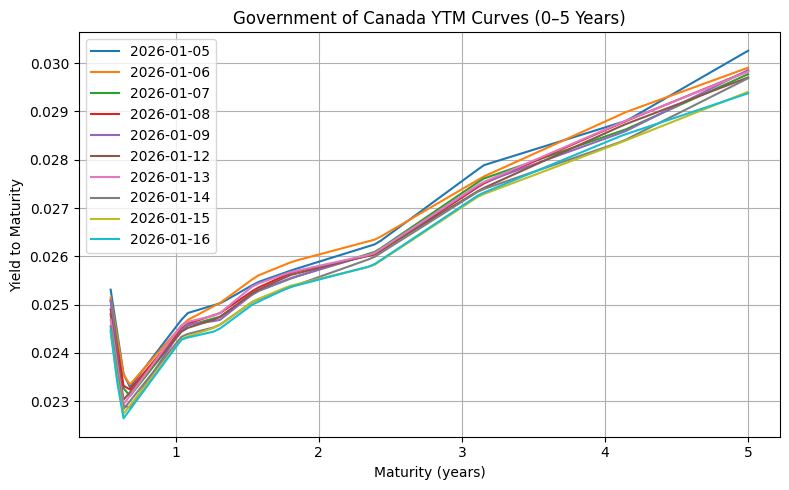

In [81]:
import os
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

T_grid = np.linspace(0.545, 5.0, 100)

plt.figure(figsize=(8,5))

for date, grp in result_df.groupby("date"):
    g = grp.sort_values("T")
    f = interp1d(g["T"].values, g["YTM"].values, kind="linear", fill_value="extrapolate")
    y_interp = f(T_grid)
    plt.plot(T_grid, y_interp, label=str(date.date()))

plt.xlabel("Maturity (years)")
plt.ylabel("Yield to Maturity")
plt.title("Government of Canada YTM Curves (0–5 Years)")
plt.legend()
plt.grid(True)
plt.tight_layout()
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/fig_yield_curve.png", bbox_inches="tight", dpi=150)
plt.show()


## Day 6 – Spot curve (bootstrapping)

In [82]:
bonds = list(zip(result_df['Dirty Price'], result_df['Coupon'], result_df['T']))
print(bonds)

[(102.56478260869565, 4.0, 0.5749486652977412), (102.57565217391304, 4.0, 0.5722108145106092), (102.58652173913043, 4.0, 0.5694729637234771), (102.59739130434782, 4.0, 0.5667351129363449), (102.59826086956522, 4.0, 0.5639972621492129), (102.62086956521739, 4.0, 0.5557837097878165), (102.63173913043478, 4.0, 0.5530458590006845), (102.64260869565217, 4.0, 0.5503080082135524), (102.65347826086956, 4.0, 0.5475701574264202), (102.65434782608695, 4.0, 0.5448323066392882), (99.49306629834254, 1.0, 0.6543463381245722), (99.49582872928177, 1.0, 0.6516084873374401), (99.518591160221, 1.0, 0.648870636550308), (99.51635359116021, 1.0, 0.6461327857631759), (99.54911602209944, 1.0, 0.6433949349760438), (99.54740331491713, 1.0, 0.6351813826146475), (99.56016574585635, 1.0, 0.6324435318275154), (99.57292817679559, 1.0, 0.6297056810403833), (99.5856906077348, 1.0, 0.6269678302532512), (99.59845303867404, 1.0, 0.6242299794661191), (101.82489130434783, 3.0, 1.0732375085557837), (101.84804347826088, 3.0, 

In [83]:
import numpy as np

def bootstrap_yield_curve(bonds):
    spot_rates = []

    # Sort by maturity
    bonds = sorted(bonds, key=lambda x: x[2])

    for i, (price, coupon, T) in enumerate(bonds):
        # Semiannual periods
        n_periods = int(np.ceil(T * 2))  # number of half-year periods
        full_coupon = coupon / 2  # semiannual coupon

        # Time periods in years
        time_periods = np.arange(1, n_periods + 1) / 2

        # Cash flows
        cash_flows = np.full(n_periods, full_coupon)
        # Adjust last cash flow for fractional period
        cash_flows[-1] = full_coupon + 100

        if i == 0:
            # First bond (usually zero-coupon)
            S = (cash_flows[-1] / price)**(1 / time_periods[-1]) - 1
        else:
            # Discount previous CFs using already calculated spot rates
            pv_prev = sum(cf / (1 + spot_rates[j])**time_periods[j] for j, cf in enumerate(cash_flows[:-1]))
            last_cf = cash_flows[-1]
            S = (last_cf / (price - pv_prev))**(1 / time_periods[-1]) - 1

        spot_rates.append(S)

    return np.array(spot_rates)

spot_curve = bootstrap_yield_curve(bonds) # bonds has coupon, dirty price, and T
result_df['Spot'] = spot_curve

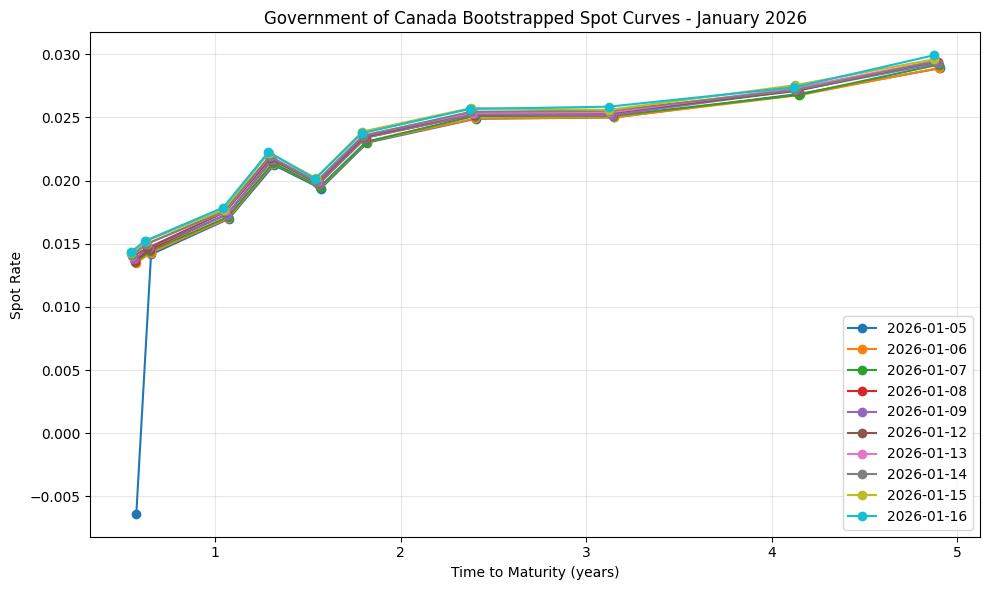

In [84]:

# Plot spot curves
plt.figure(figsize=(10,6))
for date, grp in result_df.groupby('date'):
    grp_sorted = grp.sort_values('T')
    plt.plot(grp_sorted['T'], grp_sorted['Spot'], marker='o', label=str(date.date()))
plt.xlabel("Time to Maturity (years)")
plt.ylabel("Spot Rate")
plt.title("Government of Canada Bootstrapped Spot Curves - January 2026")
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
import os
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/fig_spot_curve.png", bbox_inches="tight", dpi=150)
plt.show()


## Day 7 – Forward curve


In [85]:
print(result_df.columns)
# use semiannual coupon

Index(['date', 'ISIN', 'Dirty Price', 'YTM', 'Coupon', 'Maturity Date', 'T',
       'Spot'],
      dtype='object')


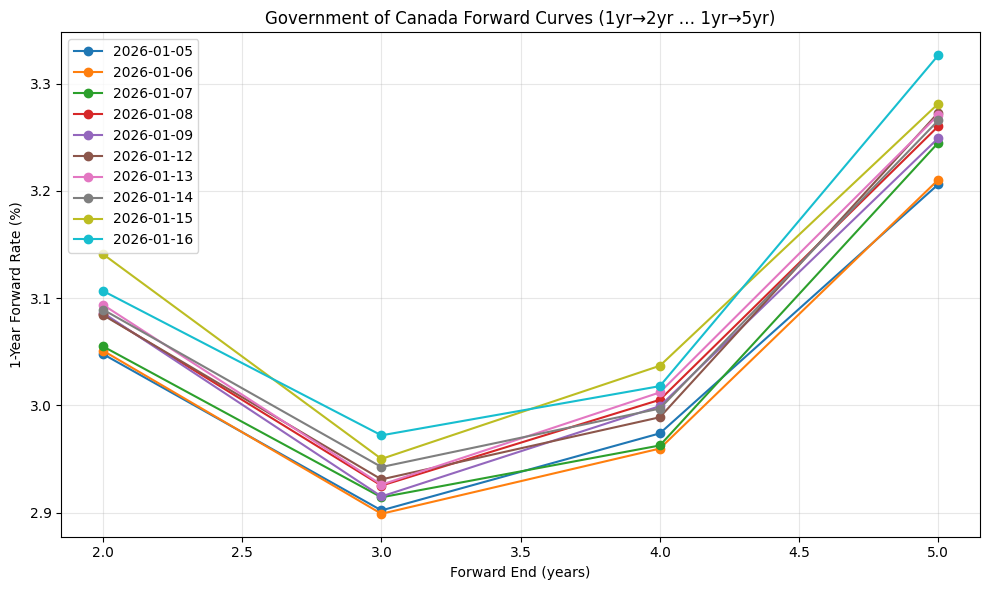

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# result_df: ['date', 'T', 'Spot', 'YTM', 'Dirty Price', 'Coupon', 'Maturity Date', 'ISIN']

forward_curves = []

for date, grp in result_df.groupby('date'):
    grp_sorted = grp.sort_values('T')
    T_vals = grp_sorted['T'].values
    S_vals = grp_sorted['Spot'].values
    
    # Convert semiannual-compounded spot rates to continuous
    S_vals_cont = 2 * np.log(1 + S_vals/2)
    
    # Interpolation function (linear for stability)
    interp = interp1d(T_vals, S_vals_cont, kind='linear', fill_value='extrapolate')
    
    # Spot at 1 year
    S_1 = float(interp(1))
    
    # Forward periods: 1yr→2yr, 1yr→3yr, 1yr→4yr, 1yr→5yr
    for end in [2, 3, 4, 5]:
        S_end = float(interp(end))  # extrapolated linearly if beyond max T
        n = end - 1  # forward period length in years
        forward_rate = (S_end * end - S_1 * 1) / n  # continuous compounding
        
        forward_curves.append({
            'date': date,
            'Start': 1,
            'End': end,
            'Forward_Rate': forward_rate
        })

# Create DataFrame
forward_df = pd.DataFrame(forward_curves)

# Convert to annual percentage for plotting
forward_df['Forward_Rate_pct'] = forward_df['Forward_Rate'] * 100

# forward_df: ['date', 'Start', 'End', 'Forward_Rate']

# Plot forward curves
plt.figure(figsize=(10,6))
for date, grp in forward_df.groupby('date'):
    plt.plot(grp['End'], grp['Forward_Rate_pct'], marker='o', label=str(date.date()))
plt.xlabel("Forward End (years)")
plt.ylabel("1-Year Forward Rate (%)")
plt.title("Government of Canada Forward Curves (1yr→2yr … 1yr→5yr)")
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
import os
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/fig_forward_curve.png", bbox_inches="tight", dpi=150)
plt.show()

## Day 8 – Log returns & covariance matrices


          Spot_1y       Spot_2y   Spot_3y   Spot_4y       Spot_5y
Spot_1y  0.000021  1.271155e-05  0.000012  0.000016  1.761790e-05
Spot_2y  0.000013  3.062509e-05  0.000001  0.000036  1.370378e-07
Spot_3y  0.000012  1.270761e-06  0.000013  0.000001  1.634154e-05
Spot_4y  0.000016  3.573211e-05  0.000001  0.000051  1.785091e-06
Spot_5y  0.000018  1.370378e-07  0.000016  0.000002  3.002648e-05


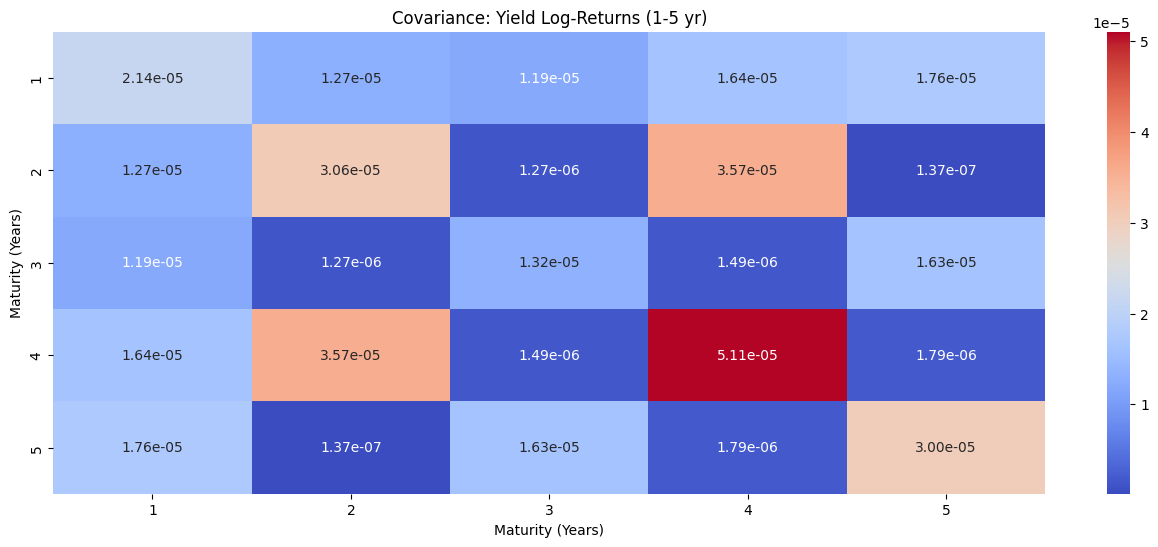

In [87]:
import seaborn as sns

target_maturities = [1, 2, 3, 4, 5]
daily_interpolated_spots = []

for date, grp in result_df.groupby('date'):
    grp_sorted = grp.sort_values('T')
    f_interp = interp1d(grp_sorted['T'], grp_sorted['Spot'], kind='linear', fill_value='extrapolate')
    day_data = {'date': date}
    for t in target_maturities:
        day_data[f'Spot_{t}y'] = float(f_interp(t))
    daily_interpolated_spots.append(day_data)

df_spots_clean = pd.DataFrame(daily_interpolated_spots).set_index('date')
log_returns_spots = np.log(df_spots_clean / df_spots_clean.shift(1)).dropna()
cov_matrix_spots = log_returns_spots.cov()


print(cov_matrix_spots)

cov_matrix_spots.index = [1, 2, 3, 4, 5]
cov_matrix_spots.columns = [1, 2, 3, 4, 5]
# Plot Heatmaps
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
sns.heatmap(cov_matrix_spots, annot=True, fmt=".2e", cmap="coolwarm", cbar=True, ax=ax)
ax.set_title("Covariance: Yield Log-Returns (1-5 yr)")
ax.set_xlabel("Maturity (Years)")
ax.set_ylabel("Maturity (Years)")
import os
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/fig_covariance_spot_rates.png", bbox_inches="tight", dpi=150)
plt.show()



In [90]:

# 2. Eigenvalues and Eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix_spots)

# 3. Sort them (highest eigenvalue first)
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

print("\nEigenvalues:")
for i, val in enumerate(eigenvalues):
    print(f"PC{i+1}: {val:.2e} ({val/sum(eigenvalues)*100:.2f}% explained)")

print("\nEigenvectors:")
for i in range(len(eigenvectors)):
    print(f"PC{i+1}: {eigenvectors[:, i]}")


Eigenvalues:
PC1: 8.67e-05 (59.24% explained)
PC2: 4.89e-05 (33.42% explained)
PC3: 4.83e-06 (3.30% explained)
PC4: 3.17e-06 (2.17% explained)
PC5: 2.74e-06 (1.87% explained)

Eigenvectors:
PC1: [-0.35763802 -0.5475572  -0.12009497 -0.72728972 -0.17000887]
PC2: [-0.39381968  0.2197008  -0.44454647  0.27111253 -0.72492348]
PC3: [ 0.55405843  0.36951909  0.25312472 -0.47082506 -0.52031388]
PC4: [ 0.57348725 -0.67244544 -0.2159802   0.32133718 -0.26272509]
PC5: [ 0.28483809  0.25136715 -0.82294354 -0.26946954  0.32531818]


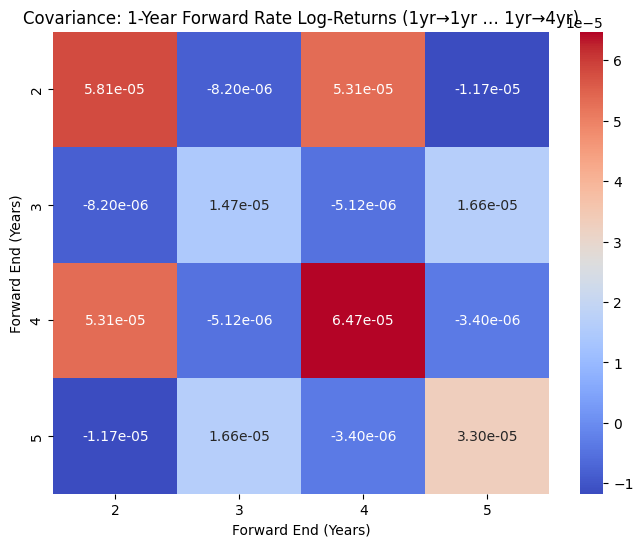


Eigenvalues (Forward Rates):
PC1: 1.17e-04 (68.75% explained)
PC2: 4.16e-05 (24.37% explained)
PC3: 7.28e-06 (4.27% explained)
PC4: 4.46e-06 (2.61% explained)

Eigenvectors:
PC1: [ 0.68101776 -0.11338874  0.70860536 -0.14572665]
PC2: [-0.01522772  0.47374138  0.26324361  0.84026188]
PC3: [-0.68924434 -0.40044277  0.60332329  0.02426586]
PC4: [ 0.24683024 -0.77611706 -0.25413038  0.52166549]


In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# forward_df: ['date', 'Start', 'End', 'Forward_Rate'] (continuous compounding)
# We have 1yr→1yr to 1yr→4yr forward rates

# 1. Pivot forward_df: rows = dates, columns = forward maturities (End)
forward_pivot = forward_df.pivot(index='date', columns='End', values='Forward_Rate')

# Optional: convert to annualized % for clarity
forward_pivot_pct = forward_pivot * 100

# 2. Compute daily log-returns
log_returns_fwd = np.log(forward_pivot_pct / forward_pivot_pct.shift(1)).dropna()

# 3. Covariance matrix
cov_matrix_fwd = log_returns_fwd.cov()

# 4. Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cov_matrix_fwd, annot=True, fmt=".2e", cmap="coolwarm", cbar=True)
plt.title("Covariance: 1-Year Forward Rate Log-Returns (1yr→1yr … 1yr→4yr)")
plt.xlabel("Forward End (Years)")
plt.ylabel("Forward End (Years)")
import os
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/fig_covariance_forward_rates.png", bbox_inches="tight", dpi=150)
plt.show()

# 5. PCA / eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix_fwd)

# Sort descending
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

print("\nEigenvalues (Forward Rates):")
for i, val in enumerate(eigenvalues):
    print(f"PC{i+1}: {val:.2e} ({val/sum(eigenvalues)*100:.2f}% explained)")

print("\nEigenvectors:")
for i in range(len(eigenvectors)):
    print(f"PC{i+1}: {eigenvectors[:, i]}")
